In [1]:
# Load and preview dataset
import datetime
import pandas as pd
import numpy as np

In [2]:
Synthetic = pd.read_csv('Synthetic_Data.csv', parse_dates=['date'])
Synthetic['ID'] = Synthetic.groupby(["country", "Series", 'S_type']).ngroup()
Synthetic.set_index('date', inplace =True)

Synthetic['ret'] = Synthetic.groupby('ID')['value'].pct_change()
Synthetic.dropna(inplace= True)

In [3]:
Synthetic_char = Synthetic[['country_gdp_factor', 'weekend_boost_factor','product_linear_trend','random_seris_type',
                            'white_noise', 'holiday_trend_factor', 'eu_industry_product_factor', 'product_seasonal_trend_factor',
                            'random_series_factor', 'wavelength', 'amplitude', 'phase', 'ID']]

Synthetic_char= Synthetic_char.reset_index().set_index(['date', 'ID'])

Synthetic_ret = Synthetic[['ID', 'ret']].pivot(columns='ID', values='ret')
Synthetic_val = Synthetic[['ID', 'value']].pivot(columns='ID', values='value')

In [4]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import copy
from sklearn.preprocessing import StandardScaler
import scipy.special as special
import scipy.sparse as sp


import os


import tensorflow as tf
#import tensorflow_addons as tfa
import keras

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, GRU, Input
from tensorflow.keras.optimizers import SGD, Adam


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dropout, Dense, LeakyReLU, GRU, Concatenate, Reshape, Softmax, Attention
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras import activations
from tensorflow.keras.models import Model
#from keras.layers import LeakyReLU

from spektral.layers import  GCSConv, DiffusionConv, GATConv, ARMAConv, GCNConv

from tensorflow.keras.regularizers import l2

Using TensorFlow backend.


In [5]:
def generate_graph_seq2seq_io_data(
        df, x_offsets, y_offsets, add_time_in_day=True, add_day_in_week=False, scaler=None
):
    """
    Generate samples from
    :param df:
    :param x_offsets:
    :param y_offsets:
    :param add_time_in_day:
    :param add_day_in_week:
    :param scaler:
    :return:
    # x: (epoch_size, input_length, num_nodes, input_dim)
    # y: (epoch_size, output_length, num_nodes, output_dim)
    """

    num_samples, num_nodes = df.shape
    data = np.expand_dims(df.values, axis=-1)
    data_list = [data]
    if add_time_in_day:
        time_ind = (df.index.values - df.index.values.astype("datetime64[D]")) / np.timedelta64(1, "D")
        time_in_day = np.tile(time_ind, [1, num_nodes, 1]).transpose((2, 1, 0))
        data_list.append(time_in_day)
    if add_day_in_week:
        day_in_week = np.zeros(shape=(num_samples, num_nodes, 7))
        day_in_week[np.arange(num_samples), :, df.index.dayofweek] = 1
        data_list.append(day_in_week)

    data = np.concatenate(data_list, axis=-1)
    # epoch_len = num_samples + min(x_offsets) - max(y_offsets)
    x, y = [], []
    # t is the index of the last observation.
    min_t = abs(min(x_offsets))
    max_t = abs(num_samples - abs(max(y_offsets)))  # Exclusive
    for t in range(min_t, max_t):
        x_t = data[t + x_offsets, ...]
        y_t = data[t + y_offsets, ...]
        x.append(x_t)
        y.append(y_t)
    x = np.stack(x, axis=0)
    y = np.stack(y, axis=0)
    return x, y



def plot_loss(dic):
    plt.figure(figsize=(12,5))
    #plt.subplot(1, 2, 1)
    plt.plot(dic['loss'], label='Training loss ')
    plt.plot(dic['val_loss'], label='Validation loss ')
    plt.legend(frameon=False)
    plt.title('train and validation loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()


    
def MSE(original, imputed):
    # calculate Mean Squared Error
    return np.square(original-imputed).mean()

def MPE(y_true, y_pred, threshold=0.1):
    v = np.copy(y_true)
    np.place(v, v==0, threshold)
    #v = np.clip(np.abs(y_true), threshold, None)
    diff = np.abs((y_true - y_pred) / v)
    return np.mean(diff, axis=-1).mean()

"""
def R_squared(original, predicted):
    Differ = np.square(original-predicted)
    m = np.mean(original) 
    denom = np.square(original - m)
    R_sq = 1 - ((Differ.sum())/denom.sum())
    return R_sq
"""
def R_squared(original, predicted):
    Differ = np.square(original-predicted)
    #m = np.mean(original) 
    denom = np.square(original)
    R_sq = 1 - ((Differ.sum())/denom.sum())
    return R_sq

def Get_performance(Y_true, Y_pred): 
    print ("R2 : ", np.round(R_squared(Y_true, Y_pred), 4))
    print ("MSE",  np.round(MSE(Y_true, Y_pred), 4))
    print ("MPE", np.round(MPE(Y_true, Y_pred), 4))
    
    return (np.round(R_squared(Y_true, Y_pred), 4), np.round(MSE(Y_true, Y_pred), 4), np.round(MPE(Y_true, Y_pred), 4)) 
        

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

def mape(y_true, y_pred, threshold=0.1):
    v = np.clip(np.abs(y_true), threshold, None)
    diff = np.abs((y_true - y_pred) / v)
    return 100.0 * np.mean(diff, axis=-1).mean()

def get_metrics(y, yp):
    return {
        "rmse": np.round(rmse(y, yp), 4),
        "mae": np.round(mae(y, yp), 4),
        "mape": np.round(mape(y, yp),4),
        #"MPE": np.round(MPE(y, yp), 4),
        #"R2": np.round(R_squared(y, yp),4)
        
    }




## LSTM

In [6]:
n_day = len(Synthetic_char.groupby('date').size())
n_firms = len(Synthetic_char.groupby('ID').size())

In [7]:
#how many time lag I wanna use
n_lag = 36
#how many time period I wanna predict
n_forward = 1

x_offsets = np.sort(np.arange(-n_lag+1, 1, 1))
y_offsets = np.sort(np.arange(1, n_forward+1, 1))

In [19]:
x, y = generate_graph_seq2seq_io_data(
    Synthetic_ret,
    x_offsets=x_offsets,
    y_offsets=y_offsets,
    add_time_in_day=False,
    add_day_in_week=False,
    )

In [20]:
x = np.transpose(x, (0, 2, 1, 3))
y = np.transpose(y, (0, 2, 1, 3))

#reshape to made three dimensional tensor
#x = x.reshape(x.shape[0],x.shape[1],x.shape[2] )
y = y.reshape(y.shape[0],y.shape[1],y.shape[2] )

#x = np.transpose(x, (0, 2, 1))
#y = np.transpose(y, (0, 2, 1))



x = x.astype('float32')
y = y.astype('float32')

In [21]:
x_train = x[:600,:,:]
y_train = y[:600,:,:]



x_val = x[600:800,:,:]
y_val = y[600:800,:,:]


x_test = x[800:,:,:]
y_test = y[800:,:,:]

In [22]:
y_test.shape

(259, 50, 1)

In [26]:
data_shape = x.shape

In [27]:
data_shape

(1059, 50, 36, 1)

In [28]:
learning_rate = 0.001
batch_size =24
epochs = 100
seed = 42
verbose = 1

In [29]:
tf.keras.backend.clear_session()

In [30]:
train_result = np.empty_like(y_train)
val_result = np.empty_like(y_val)
test_result = np.empty_like(y_test)

for i in range(0, x_train.shape[1]):
#for i in range(0, 4):
    print("Firm ID+++++=======   ", i)
    tf.keras.backend.clear_session()
    
    inputs = Input(shape=(data_shape[2],data_shape[3], ))
    LSTM_1 = LSTM(10, activation="tanh", dropout=0.2, return_sequences=True)(inputs)
    LSTM_2 = LSTM(8, activation="relu", dropout=0.2, return_sequences=False)(LSTM_1)
    #dense_out = Dense(8, activation='linear')(LSTM_2)
    #dense_out = Dropout(0.2)(dense_out)
    outputs = Dense(1)(LSTM_2)
    
    model = Model(inputs=inputs, outputs=outputs)   
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    model.summary()
    
    model.fit((x_train[:,i,:,:]), (y_train[:,i,:]), epochs= epochs, batch_size= batch_size,
              validation_data=(x_val[:,i,:,:], y_val[:,i,:]),
              callbacks=[EarlyStopping(#monitor="val_mean_absolute_error", 
              monitor="val_loss", patience=10, restore_best_weights=True)])
    
    train_pred = model.predict(x_train[:,i,:,:])
    val_pred = model.predict(x_val[:,i,:,:])
    test_pred = model.predict(x_test[:,i,:,:])
    
    train_result[:,i,:] =  train_pred
    val_result[:,i,:] =  val_pred
    test_result[:,i,:] =  test_pred

Firm ID+++++=======    0
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 36, 10)            480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 608       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 1,097
Trainable params: 1,097
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 1s 36ms/step - loss: 0.0080 - val_loss: 0.0087
Epoch 2/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0079 - val_loss: 0.0086
Epoch 3/100
25/25 [======

25/25 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 33/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 34/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0087
Epoch 35/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 36/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 37/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 38/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 39/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 40/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 41/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0085
Epo

25/25 [==============================] - 1s 21ms/step - loss: 0.0079 - val_loss: 0.0056
Epoch 36/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0082 - val_loss: 0.0058
Epoch 37/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0079 - val_loss: 0.0056
Epoch 38/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0077 - val_loss: 0.0056
Epoch 39/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0073 - val_loss: 0.0055
Epoch 40/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0074 - val_loss: 0.0055
Epoch 41/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0075 - val_loss: 0.0059
Epoch 42/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0078 - val_loss: 0.0056
Epoch 43/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0074 - val_loss: 0.0057
Epoch 44/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0079 - val_loss: 0.0057
Epo

25/25 [==============================] - 1s 21ms/step - loss: 0.0087 - val_loss: 0.0070
Epoch 35/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0069
Epoch 36/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0087 - val_loss: 0.0069
Epoch 37/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0084 - val_loss: 0.0068
Epoch 38/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0068
Epoch 39/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0084 - val_loss: 0.0067
Epoch 40/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0084 - val_loss: 0.0067
Epoch 41/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0083 - val_loss: 0.0066
Epoch 42/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0083 - val_loss: 0.0066
Epoch 43/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0066
Epo

25/25 [==============================] - 1s 21ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 44/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 45/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 46/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0061 - val_loss: 0.0054
Firm ID+++++=======    10
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 36, 10)            480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 608       
_________________________________________________________________
dense (Dense)                (Non

25/25 [==============================] - 1s 21ms/step - loss: 0.0087 - val_loss: 0.0075
Epoch 12/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0072
Epoch 13/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0072
Epoch 14/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0072
Epoch 15/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0083 - val_loss: 0.0072
Epoch 16/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0084 - val_loss: 0.0072
Epoch 17/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0082 - val_loss: 0.0071
Epoch 18/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0083 - val_loss: 0.0071
Epoch 19/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0083 - val_loss: 0.0071
Epoch 20/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0081 - val_loss: 0.0071
Epo

25/25 [==============================] - 1s 21ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 35/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 36/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0070 - val_loss: 0.0061
Epoch 37/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0070 - val_loss: 0.0061
Epoch 38/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 39/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 40/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 41/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 42/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 43/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0066 - val_loss: 0.0059
Epo

25/25 [==============================] - 1s 21ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 41/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 42/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 43/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 44/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 45/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 46/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 47/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 48/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 49/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0068 - val_loss: 0.0063
Epo

25/25 [==============================] - 1s 21ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 30/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0059 - val_loss: 0.0061
Epoch 31/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 32/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 33/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 34/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 35/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0061 - val_loss: 0.0061
Firm ID+++++=======    19
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 1)]           0         
____________________________________________________________

25/25 [==============================] - 1s 21ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 39/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0080 - val_loss: 0.0062
Epoch 40/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0082 - val_loss: 0.0061
Epoch 41/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0078 - val_loss: 0.0060
Epoch 42/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0078 - val_loss: 0.0060
Epoch 43/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0078 - val_loss: 0.0062
Epoch 44/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0083 - val_loss: 0.0061
Epoch 45/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0080 - val_loss: 0.0060
Epoch 46/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0083 - val_loss: 0.0062
Epoch 47/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0076 - val_loss: 0.0060
Epo

25/25 [==============================] - 1s 21ms/step - loss: 0.0073 - val_loss: 0.0058
Epoch 30/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0072 - val_loss: 0.0058
Epoch 31/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0077 - val_loss: 0.0059
Epoch 32/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0076 - val_loss: 0.0058
Firm ID+++++=======    24
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 36, 10)            480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 608       
_________________________________________________________________
dense (Dense)                (Non

25/25 [==============================] - 1s 21ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 45/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0070 - val_loss: 0.0058
Epoch 46/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 47/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0070 - val_loss: 0.0059
Epoch 48/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 49/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0071 - val_loss: 0.0060
Epoch 50/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0070 - val_loss: 0.0058
Epoch 51/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0070 - val_loss: 0.0057
Epoch 52/100
25/25 [==============================] - 0s 20ms/step - loss: 0.0070 - val_loss: 0.0058
Epoch 53/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0071 - val_loss: 0.0058
Epo

25/25 [==============================] - 1s 21ms/step - loss: 0.0088 - val_loss: 0.0072
Epoch 15/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0089 - val_loss: 0.0072
Epoch 16/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0087 - val_loss: 0.0070
Epoch 17/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0087 - val_loss: 0.0069
Epoch 18/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0069
Epoch 19/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0068
Epoch 20/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0067
Epoch 21/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0067
Epoch 22/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0082 - val_loss: 0.0065
Epoch 23/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0081 - val_loss: 0.0064
Epo

25/25 [==============================] - 1s 36ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 2/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 3/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 4/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 5/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 6/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 7/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0088
Epoch 8/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0088
Epoch 9/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0088
Epoch 10/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0088
Epoch 11/10

25/25 [==============================] - 1s 37ms/step - loss: 0.0089 - val_loss: 0.0081
Epoch 2/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0090 - val_loss: 0.0080
Epoch 3/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0089 - val_loss: 0.0079
Epoch 4/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0089 - val_loss: 0.0079
Epoch 5/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0088 - val_loss: 0.0078
Epoch 6/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0089 - val_loss: 0.0077
Epoch 7/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0087 - val_loss: 0.0077
Epoch 8/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0087 - val_loss: 0.0076
Epoch 9/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0087 - val_loss: 0.0075
Epoch 10/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0074
Epoch 11/10

25/25 [==============================] - 1s 21ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 20/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 21/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 22/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 23/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 24/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 25/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 26/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 27/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 28/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0065 - val_loss: 0.0060
Epo

25/25 [==============================] - 1s 21ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 21/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 22/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 23/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 24/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 25/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 26/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 27/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 28/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 29/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0067 - val_loss: 0.0060
Epo

25/25 [==============================] - 1s 21ms/step - loss: 0.0072 - val_loss: 0.0089
Epoch 38/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0073 - val_loss: 0.0088
Epoch 39/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0070 - val_loss: 0.0083
Epoch 40/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0070 - val_loss: 0.0081
Epoch 41/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0069 - val_loss: 0.0081
Epoch 42/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0069 - val_loss: 0.0079
Epoch 43/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0069 - val_loss: 0.0078
Epoch 44/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0068 - val_loss: 0.0076
Epoch 45/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0068 - val_loss: 0.0076
Epoch 46/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0065 - val_loss: 0.0075
Epo

25/25 [==============================] - 1s 36ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 2/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 3/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 4/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 5/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 6/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 7/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 8/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 9/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 10/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 11/10

25/25 [==============================] - 1s 35ms/step - loss: 0.0084 - val_loss: 0.0094
Epoch 2/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0084 - val_loss: 0.0094
Epoch 3/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0084 - val_loss: 0.0094
Epoch 4/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0083 - val_loss: 0.0093
Epoch 5/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0083 - val_loss: 0.0094
Epoch 6/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0084 - val_loss: 0.0093
Epoch 7/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0084 - val_loss: 0.0094
Epoch 8/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0083 - val_loss: 0.0093
Epoch 9/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0083 - val_loss: 0.0094
Epoch 10/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0084 - val_loss: 0.0093
Epoch 11/10

25/25 [==============================] - 1s 21ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 27/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 28/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 29/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0070 - val_loss: 0.0053
Epoch 30/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0067 - val_loss: 0.0058
Epoch 31/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 32/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0062 - val_loss: 0.0053
Epoch 33/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 34/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0062 - val_loss: 0.0051
Epoch 35/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0065 - val_loss: 0.0056
Epo

In [31]:
get_metrics(y_train.flatten(), train_result.flatten())

{'mae': 0.0595, 'mape': 49.3718, 'rmse': 0.075}

In [32]:
get_metrics(y_val.flatten(), val_result.flatten())

{'mae': 0.0601, 'mape': 49.6686, 'rmse': 0.0759}

In [69]:
get_metrics(y_test.flatten(), test_result.flatten())

{'mae': 0.0595, 'mape': 49.2249, 'rmse': 0.0754}

In [74]:
y_test_2  = y_test.reshape(y_test.shape[0],y_test.shape[1])
pred_test_2  =  test_result.reshape( test_result.shape[0], test_result.shape[1])

In [75]:
LSTM_test_result = pd.DataFrame(pred_test_2, index = Synthetic_ret.index[-pred_test_2.shape[0]:], columns = Synthetic_ret.columns)

In [81]:
LSTM_test_result.to_csv("LSTM_test_result.csv")

In [82]:
LSTM_test_result

ID,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
date,,,,,,,,,,,,,,,,,,,,,
2019-04-18,0.037559,0.060470,0.072226,0.042355,0.029816,0.039911,0.052312,0.080030,0.059206,0.017077,...,0.016205,0.041062,0.072044,0.019910,0.034992,0.078056,0.032856,0.056412,0.073868,0.032525
2019-04-19,0.024487,0.073506,0.098577,-0.037178,-0.010059,-0.025521,0.047110,0.073650,-0.004992,0.011560,...,0.024664,0.009579,0.070992,0.041432,0.044682,-0.000226,0.058614,0.100549,-0.051433,0.016744
2019-04-20,0.054720,0.012771,0.079291,-0.008584,-0.020159,-0.005230,0.014109,0.052748,0.015142,-0.045154,...,-0.004075,0.031605,0.038531,-0.060006,0.002567,-0.051402,0.051132,0.033119,-0.009383,-0.003229
2019-04-21,-0.015773,0.033160,0.048171,0.007562,-0.012705,0.019601,0.039589,0.086009,0.055531,0.019605,...,0.051470,0.011123,0.090315,0.018255,0.013990,0.009835,0.033132,0.090076,0.053066,0.045299
2019-04-22,-0.023630,0.047889,0.082067,0.026557,0.064949,0.025517,0.030548,0.062044,0.061524,0.030481,...,-0.018546,0.025450,0.078268,-0.008786,0.074045,0.029552,0.001768,0.083311,0.010789,0.054501
2019-04-23,0.045354,-0.012852,0.067435,0.025457,-0.026372,0.005760,0.018469,0.099732,0.038296,0.009449,...,-0.004501,0.025184,0.039556,0.029290,-0.037324,0.123866,-0.024677,0.097346,0.006494,0.041824
2019-04-24,-0.044718,-0.068563,0.012040,-0.042593,-0.052648,-0.014471,-0.090665,0.000178,-0.076581,-0.049792,...,-0.072112,-0.006540,0.060922,-0.065993,-0.024826,-0.075198,-0.018146,0.038698,-0.016434,-0.081791
2019-04-25,0.014474,-0.023934,0.096939,0.002450,0.054550,0.020676,-0.004793,0.059316,0.040499,0.005985,...,0.005636,-0.025572,0.012609,0.033879,0.024351,-0.014309,0.059323,0.064685,0.030910,0.051365
2019-04-26,0.051022,-0.021003,0.085234,0.029576,-0.025541,0.020316,-0.002867,0.085142,-0.011377,0.038113,...,-0.012019,-0.007335,0.074686,0.030053,0.000321,0.057935,0.014842,-0.007159,0.025986,0.072199


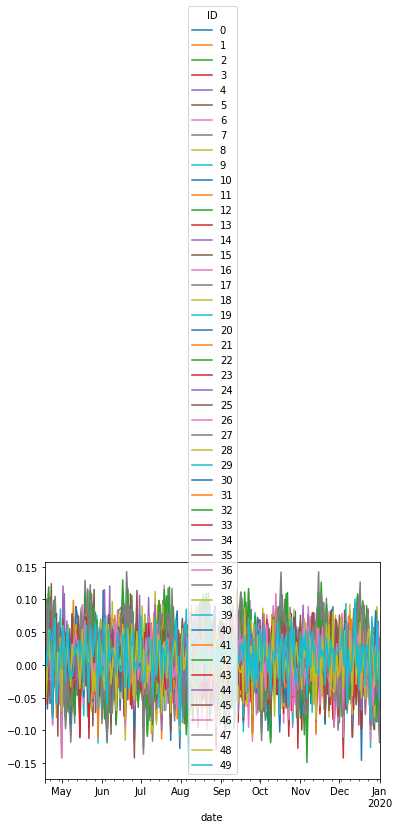

In [79]:
LSTM_test_result.plot()

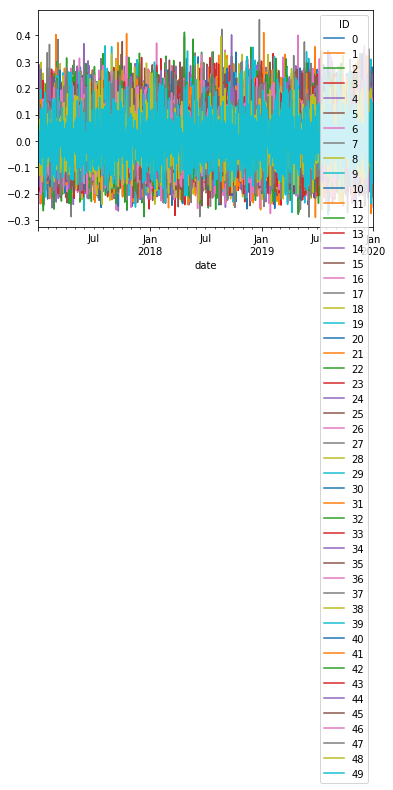

In [80]:
Synthetic_ret.plot()

In [38]:
#np.savetxt('LSTM_test_result.csv', test_result.flatten(), delimiter=",") 

In [42]:
# To read the file into numpy data. 
#np.genfromtxt('LSTM_test_result.csv',delimiter=',')

## ARIMA 

In [47]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [54]:
train_data = Synthetic_ret[:800]
test_data = Synthetic_ret[800:]

In [57]:
SARIMAX_result = np.empty_like(test_data)

for i in range(339, train_data.shape[1]):
    AR_model = SARIMAX(train_data.iloc[:,i], order=(24,1,12))
    results = AR_model.fit()
    SAR_pred = results.forecast(test_data.shape[0])
    print(i)
    SARIMAX_result[:,i] =  SAR_pred

In [62]:
SARIMAX_result.shape

(295, 50)

In [ ]:
get_metrics(tra.values.flatten(), SARIMAX_result.flatten())

In [ ]:
#np.savetxt('LSTM_test_result.csv', test_result.flatten(), delimiter=",") 

In [64]:
get_metrics(test_data.values.flatten(), SARIMAX_result.flatten())

{'mae': 0.0749, 'mape': 60.7537, 'rmse': 0.0944}

In [66]:
ARIMA_test_result = pd.DataFrame(SARIMAX_result, index = test_data.index ,columns =test_data.columns )

In [68]:
ARIMA_test_result.to_csv("ARIMA_test_result.csv")

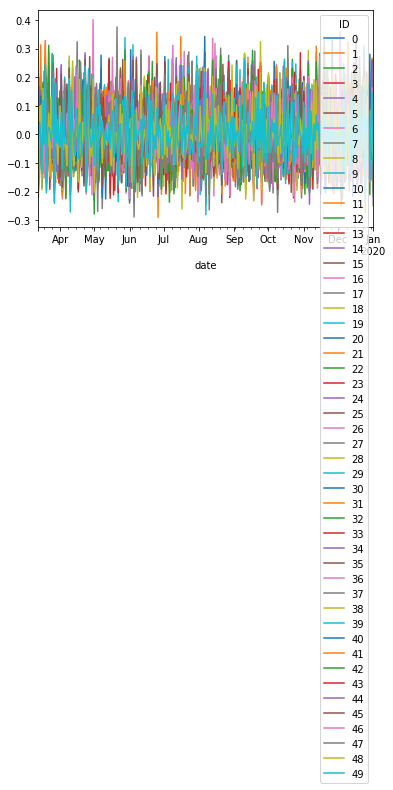

In [73]:
test_data.plot()

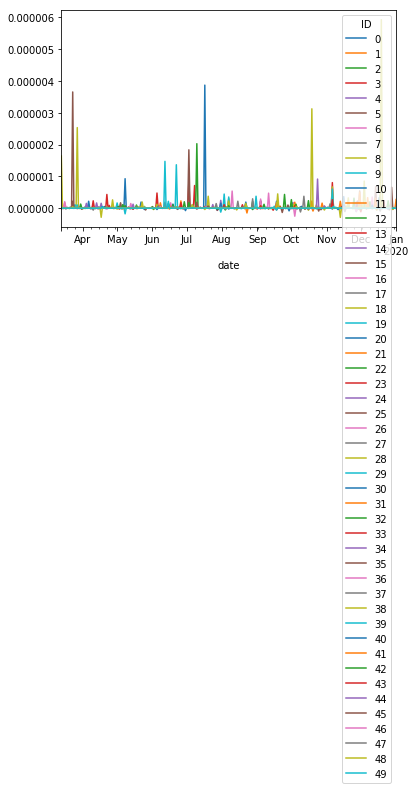

In [72]:
ARIMA_test_result.plot()

### MLP

In [129]:
x_train = Synthetic_char[Synthetic_char.index.get_level_values(0) <'2018-08-25']
x_val = Synthetic_char[(Synthetic_char.index.get_level_values(0) >= '2018-08-25') & (Synthetic_char.index.get_level_values(0) < '2019-03-13')] 
x_test = Synthetic_char[(Synthetic_char.index.get_level_values(0) >=  '2019-03-13')]

In [130]:
#Do Standardization
#standardization
scaler = StandardScaler()
#scaler.fit(data)
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [148]:
Synthetic_ret_MLP = Synthetic[['ID', 'ret']]
Synthetic_ret_MLP = Synthetic_ret_MLP.reset_index().set_index(['date', 'ID'])

In [149]:
y_train = Synthetic_ret_MLP[Synthetic_ret_MLP.index.get_level_values(0) <'2018-08-25'].values

y_val = Synthetic_ret_MLP[(Synthetic_ret_MLP.index.get_level_values(0) >= '2018-08-25') & (Synthetic_ret_MLP.index.get_level_values(0) < '2019-03-13')].values

y_test = Synthetic_ret_MLP[(Synthetic_ret_MLP.index.get_level_values(0) >=  '2019-03-13')].values

In [155]:
learning_rate = 0.001
batch_size =54
epochs = 300
seed = 7
verbose = 1

In [156]:
tf.keras.backend.clear_session()
    
inputs = Input(shape=(x_train.shape[1], ))
Dense_1 = Dense(32, activation="relu")(inputs)
#Dense_1 = Dropout(0.20)(Dense_1)
Dense_2 = Dense(16, activation="relu")(Dense_1)
#Dense_2 = Dropout(0.20)(Dense_2)
dense_3 = Dense(8, activation='linear')(Dense_2)
#dense_3 = Dropout(0.1)(dense_3)
outputs = Dense(1)(dense_3)
    
model = Model(inputs=inputs, outputs=outputs)   
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                416       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,089
Trainable params: 1,089
Non-trainable params: 0
_________________________________________________________________


In [157]:
hists =  model.fit(x_train, y_train, epochs= epochs, batch_size= batch_size, shuffle = True, 
          validation_data=[x_val, y_val],
          callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)])

Epoch 1/300
556/556 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0000e+00
Epoch 2/300
556/556 [==============================] - 1s 1ms/step - loss: 0.0047 - val_loss: 0.0000e+00
Epoch 3/300
556/556 [==============================] - 1s 1ms/step - loss: 0.0044 - val_loss: 0.0000e+00
Epoch 4/300
556/556 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0000e+00
Epoch 5/300
556/556 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0000e+00
Epoch 6/300
556/556 [==============================] - 1s 1ms/step - loss: 0.0042 - val_loss: 0.0000e+00
Epoch 7/300
556/556 [==============================] - 0s 802us/step - loss: 0.0042 - val_loss: 0.0000e+00
Epoch 8/300
556/556 [==============================] - 0s 826us/step - loss: 0.0042 - val_loss: 0.0000e+00
Epoch 9/300
556/556 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0000e+00
Epoch 10/300
556/556 [=============================

In [158]:
train_predicted = model.predict(x_train)
get_metrics(y_train.flatten(), train_predicted.flatten())

{'mae': 0.0569, 'mape': 49.7603, 'rmse': 0.0716}

In [159]:
val_predicted = model.predict(x_val)
get_metrics(y_val.flatten(), val_predicted.flatten())

{'mae': 0.0583, 'mape': 50.8032, 'rmse': 0.0731}

In [161]:
test_predicted = model.predict(x_test)
get_metrics(y_test.flatten(), test_predicted.flatten())

{'mae': 0.0636, 'mape': 55.5862, 'rmse': 0.08}

In [182]:
MLP_test_result =  pd.DataFrame(test_predicted, index = Synthetic_ret_MLP[(Synthetic_ret_MLP.index.get_level_values(0) >=  '2019-03-13')].index)

In [188]:
MLP_test_result = MLP_test_result.reset_index().set_index('date').pivot(columns='ID', values=0)

In [195]:
MLP_test_result.to_csv("MLP_test_result.csv")

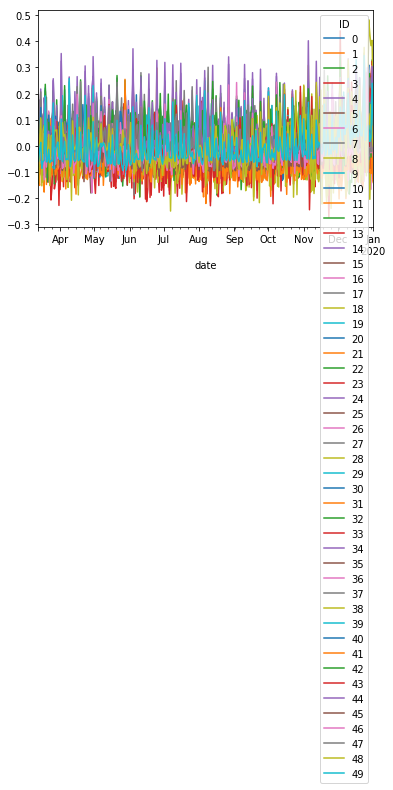

In [194]:
MLP_test_result.plot()

## Linear Regression

In [217]:
from sklearn.linear_model import LinearRegression

In [218]:
reg = LinearRegression().fit(x_train, y_train)

In [219]:
train_predicted = reg.predict(x_train)
get_metrics(y_train.flatten(), train_predicted.flatten())


{'mae': 0.0511, 'mape': 44.3988, 'rmse': 0.0642}

In [220]:
test_predicted = reg.predict(x_test)
get_metrics(y_test.flatten(), test_predicted.flatten())

{'mae': 0.051, 'mape': 44.3047, 'rmse': 0.064}

In [222]:
test_predicted.shape

(14750, 1)

In [223]:
REg_test_result =  pd.DataFrame(test_predicted, index = Synthetic_ret_MLP[(Synthetic_ret_MLP.index.get_level_values(0) >=  '2019-03-13')].index)

In [224]:
REg_test_result = REg_test_result.reset_index().set_index('date').pivot(columns='ID', values=0)

In [226]:
REg_test_result.to_csv("REg_test_result.csv")

## SVR 

In [228]:
from sklearn.svm import SVR

In [229]:
svr_Reg = SVR(C=1.0, epsilon=0.2).fit(x_train, y_train)

/home/ajim/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [230]:
svr_predicted = svr_Reg.predict(x_train)
get_metrics(y_train.flatten(), svr_predicted.flatten())

{'mae': 0.0567, 'mape': 48.9486, 'rmse': 0.0707}

In [231]:
test_predicted_SVR = svr_Reg.predict(x_test)
get_metrics(y_test.flatten(), test_predicted_SVR.flatten())

{'mae': 0.0586, 'mape': 49.9343, 'rmse': 0.0731}

In [233]:
SVR_test_result =  pd.DataFrame(test_predicted_SVR, index = Synthetic_ret_MLP[(Synthetic_ret_MLP.index.get_level_values(0) >=  '2019-03-13')].index)

In [234]:
SVR_test_result  = SVR_test_result.reset_index().set_index('date').pivot(columns='ID', values=0)

In [237]:
SVR_test_result.to_csv("SVR_test_result.csv")

## Random Forest

In [238]:
from sklearn.ensemble import RandomForestRegressor

In [239]:
regforest = RandomForestRegressor(max_depth=10, random_state=0)
regforest.fit(x_train, y_train)

/home/ajim/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ajim/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [240]:
for_predicted = regforest.predict(x_train)
get_metrics(y_train.flatten(), for_predicted.flatten())

{'mae': 0.0477, 'mape': 41.6546, 'rmse': 0.0599}

In [241]:
test_predicted_forest = regforest.predict(x_test)
get_metrics(y_test.flatten(), test_predicted_forest.flatten())

{'mae': 0.0538, 'mape': 46.8725, 'rmse': 0.0676}

In [242]:
RandFor_test_result =  pd.DataFrame(test_predicted_forest, index = Synthetic_ret_MLP[(Synthetic_ret_MLP.index.get_level_values(0) >=  '2019-03-13')].index)

In [244]:
RandFor_test_result = RandFor_test_result.reset_index().set_index('date').pivot(columns='ID', values=0)

In [247]:
RandFor_test_result.to_csv("RandFor_test_resultv.csv")
